In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from IPython.display import Image
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None 

In [2]:
class TrainLSTMModel:
    def __init__(self, data_source):
        self.data_source = data_source

    def getData(self):
        """
        getData gets stock quote data from provided web source
        
        return: the extracted dataset
        """
        df = web.DataReader(self.data_source, data_source = "yahoo", start = "2000-01-01", end = "2020-12-31")
        self.viz_data(df)
        return self.data_manipulation(df)
        
    # Visualize closing price
    def viz_data(self, df):
        """
        viz_data visualizes the data
        
        param df: data to be visualized
        """
        plt.figure(figsize=(16,8))
        plt.title("Closing Price History")
        plt.plot(df["Close"])
        plt.xlabel("Date", fontsize=18)
        plt.ylabel("Closing Price USD ($)", fontsize=18)
        plt.show()
        
    def data_manipulation(self, df):
        """
        data_manipulation: performs operations to extract
                relevant information from a given dataset.
        param df: data to be processed
        return: a chain of segmented data points
        """
        # Get close column
        data = df.filter(["Close"])

        # To numpy array
        dataset = data.values
        
        # Data normalization
        scaler = MinMaxScaler(feature_range=(0,1))
        scaled_data = scaler.fit_transform(dataset)
        
        # Create training data set (80% of data)
        training_data_len = math.ceil(len(dataset) * .8)
        train_data = scaled_data[0:training_data_len, :]

        # Split into x_train and y_train
        x_train = []
        y_train = []

        # Get data for past 60 days from start point 
        for i in range(60, len(train_data)):
            x_train.append(train_data[i-60:i, 0])
            y_train.append(train_data[i,0])
            """"
            if i <= 90:
                print(x_train)
                print(y_train)
                print()
            """
                
        # Conver train to numpy arrays
        x_train, y_train = np.array(x_train), np.array(y_train)
        
        # Reshape data
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        return x_train, y_train, training_data_len, scaled_data, data, dataset, scaler
        
        
    def buildLSTM(self, x_train):
        """
        buildLSTM: builds an LSTM model
        
        param x_train: data used for training
        return: the created model
        """
        model = Sequential()
        model.add(LSTM(50, return_sequences= True, input_shape = (x_train.shape[1], 1)))
        model.add(LSTM(50, return_sequences= False))
        model.add(Dense(25))
        model.add(Dense(1))
        print(model.summary())
        return model

    def train(self):
        """
        train: compiles and trains model.
                Also serves as program driver
        """
        x_train, y_train, training_data_len, scaled_data, data, dataset, scaler = self.getData()
        model = self.buildLSTM(x_train)
        model.compile(optimizer="adam", loss="mean_squared_error")
        model.fit(x_train, y_train, batch_size=1, epochs=1)
        self.test(data, scaled_data, training_data_len, dataset, model, scaler)

    def test(self, data, scaled_data, training_data_len, dataset, model, scaler):
        """
        test: tests model performance
        
        param data: full data
        param scaled_data: scaled version of data
        param training_data_len: stores length of data
        param dataset: contains values of data
        param model: LSTM model
        param: scaler: min max scaler instance
        """
        # Scale values fom index 1752 to end of dataset
        test_data = scaled_data[training_data_len -60:, :]

        # x, y test data
        x_test = []
        y_test = dataset[training_data_len:, :]
        
        for i in range(60, len(test_data)):
            x_test.append(test_data[i-60:i,0])
        
        # reshape because LSTM expects 3D shape
        x_test = np.array(x_test)
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        predictions = self.predict(model, x_test, y_test, scaler)
        self.plotOutput(data, training_data_len, predictions)
        
        

    def predict(self, model, x_test, y_test, scaler):
        """
        predict: performs predictions on model
        
        param model: LSTM model
        param: x_test: x data for testing
        param: y_test: y data for testing
        return: predicted values
        """
        
        # Get predictions
        predictions = model.predict(x_test)

        # Unscaling values to match values in y_test dataset 
        predictions = scaler.inverse_transform(predictions)

        # Get mean square error
        rmse = np.sqrt(np.mean(predictions - y_test)**2)
        #print("rmse: ", rmse)
        return predictions

    def plotOutput(self, data, training_data_len, predictions):
        """
        Plots model performance against actual data
        
        param data: full data
        param training_data_len: stores length of data
        param predictions: predicted values
        """
        # Plot accuracy
        train = data[:training_data_len]
        valid = data[training_data_len:]
        valid["Predictions"] = predictions
        plt.figure(figsize=(16, 8))
        plt.title("Model")
        plt.xlabel("Data", fontsize = 18)
        plt.ylabel("Close Price USD ($", fontsize=18)
        plt.plot(train["Close"])
        plt.plot(valid[["Close", "Predictions"]])
        plt.legend(["Train", "val", "Predictions"], loc = "lower right")
        plt.show()
        print(valid)     

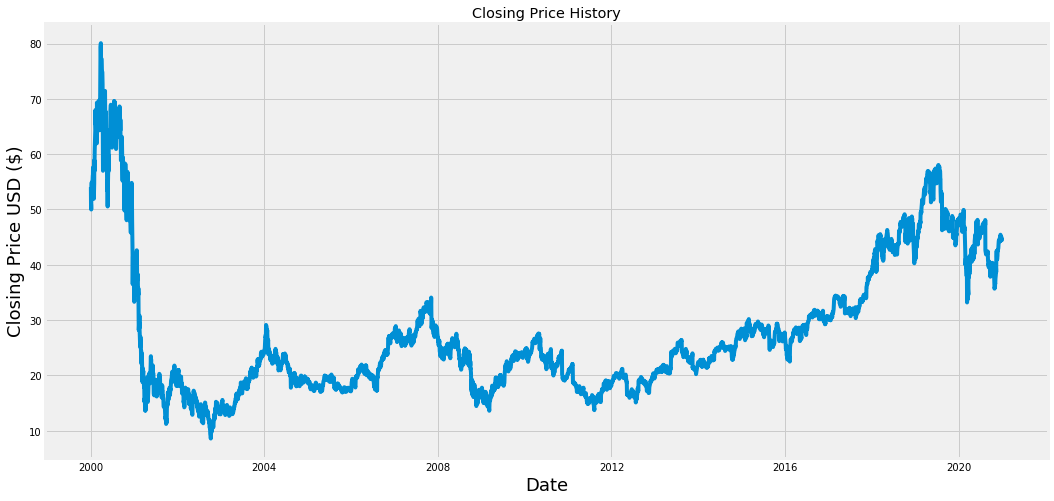

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________
None
4168/4168 [==============================] - 82s 20ms/step - loss: 9.8341e-04


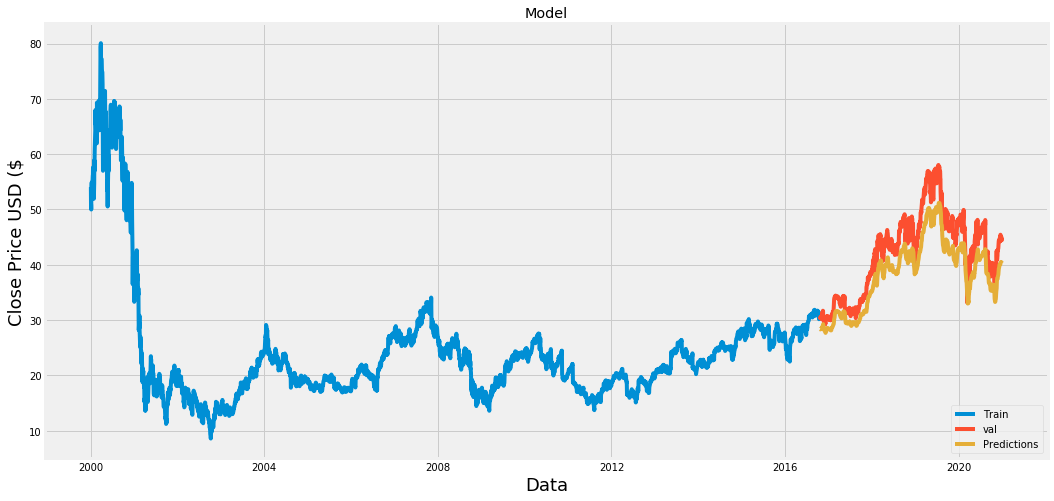

                Close  Predictions
Date                              
2016-10-21  30.150000    28.368444
2016-10-24  30.459999    28.330215
2016-10-25  30.340000    28.354176
2016-10-26  30.549999    28.373083
2016-10-27  30.379999    28.423061
...               ...          ...
2020-12-24  44.540001    40.419521
2020-12-28  44.919998    40.350079
2020-12-29  44.639999    40.370712
2020-12-30  44.480000    40.365932
2020-12-31  44.750000    40.327190

[1056 rows x 2 columns]


In [3]:
# Instantiate class with company of choice
train = TrainLSTMModel("CSCO")
train.train()